# 1. Reposo

Señal: /Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/Reposo.txt | len(x)=49650 | FS=1000.0 Hz
Filtros a procesar (4 distintos): ['Butterworth_bp4', 'ChebyshevI_bp4_rp1', 'Bessel_bp4', 'FIR_Hamming_121taps']


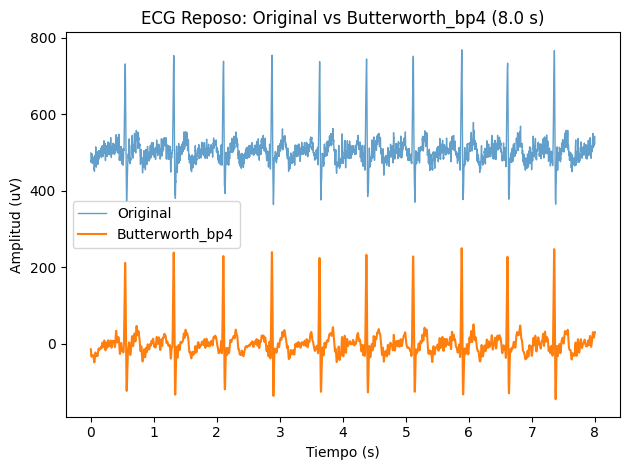

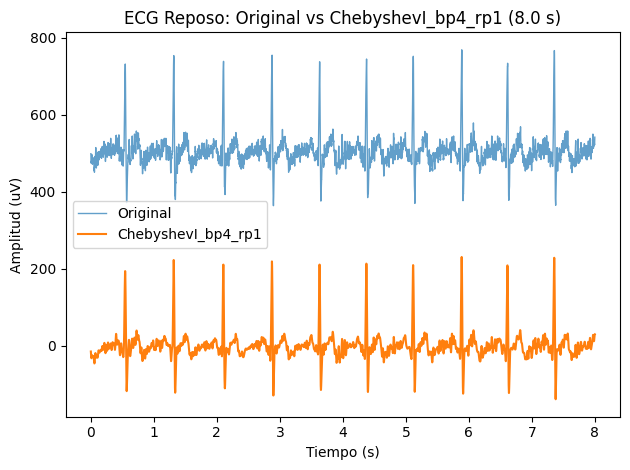

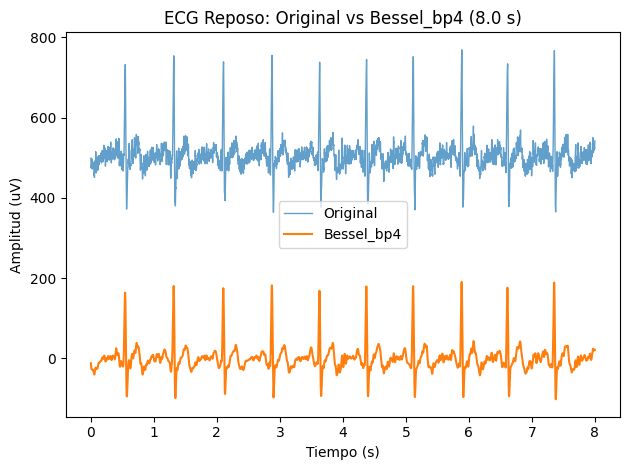

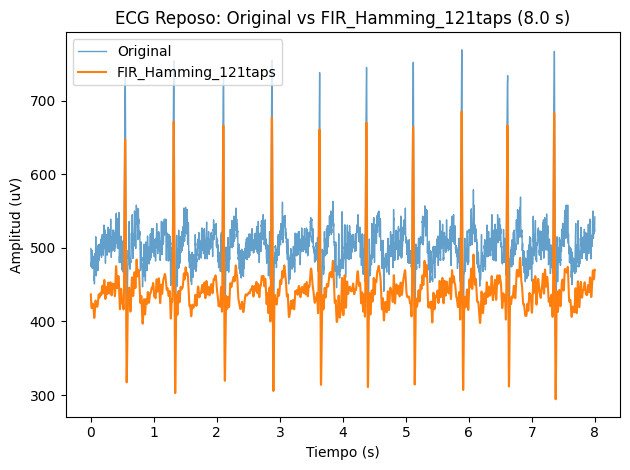


Resumen (para control):
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
FIR_Hamming_121taps     42.972485    0.0    120
ChebyshevI_bp4_rp1      37.233062    0.0      8
Bessel_bp4              36.901099    0.0      8
Butterworth_bp4         34.385121    0.0      8


In [ ]:
# ==========================================================
# ECG Reposo: aplica 4 filtros DISTINTOS
# ==========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Se incluyen todos los tipos IIR y FIR necesarios
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq

# ---------- Rutas según tu estructura (Ajustado a Data_ECG_L6) ----------
BASE = os.getcwd()

def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

# La carpeta de datos
DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "Reposo.txt")


# ---------- Parámetros ----------
FS = 1000.0           # Hz (ajústalo si tu muestreo real es otro)
BANDA = (0.5, 40.0)   # ECG en reposo
APLICAR_NOTCH = True
F0_NOTCH = 60.0       # Perú
Q_NOTCH = 30.0
ZERO_PHASE = True     # compara sin desfase cuando sea posible

# ---------- Utilidades (sin cambios) ----------
def cargar_coef_pyfda(path):
    if not os.path.exists(path):
        return None, None
    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]
    b = a = None
    if "b" in df.columns and "a" in df.columns:
        b = df["b"].dropna().to_numpy(float)
        a = df["a"].dropna().to_numpy(float)
    elif "b" in df.columns:
        b = df["b"].dropna().to_numpy(float)
        a = np.array([1.0])
    else:
        for cand in ("coef","coeff","num","numerator"):
            if cand in df.columns:
                b = df[cand].dropna().to_numpy(float)
                a = np.array([1.0]); break
    return b, a

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)

def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    if zero_phase and _can_filtfilt(x, b, a):
        return filtfilt(b, a, x)
    return lfilter(b, a, x)

def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q)
    return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)

# Funciones de diseño
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]
    return butter(order, wn, btype="band")

def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]
    return cheby1(order, rp, wn, btype="band")

def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]
    return bessel(order, wn, btype="band")

def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window)
    return b, np.array([1.0])

def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x)
    X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs)
    m = (freqs >= f1) & (freqs <= f2)
    return X[m].sum()

def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) \
           + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref))
    lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}

# ---------- Cargar señal ----------
data = np.loadtxt(RUTA_SENIAL)
x = np.asarray(data, float)
if x.ndim == 2:
    x = x[:, -1]
t = np.arange(len(x)) / FS
print(f"Señal: {RUTA_SENIAL} | len(x)={len(x)} | FS={FS} Hz")

# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS (Garantizados) ----------
f1, f2 = BANDA
filtros = []

# 1) Butterworth pasabanda (IIR, respuesta plana)
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4)
filtros.append(("Butterworth_bp4", b_but, a_but))

# 2) Chebyshev I pasabanda (IIR, transición abrupta)
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0)
filtros.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))

# 3) Bessel pasabanda (IIR, fase lineal)
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4)
filtros.append(("Bessel_bp4", b_bes, a_bes))

# 4) FIR Hamming (FIR, fase lineal inherente)
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming")
filtros.append(("FIR_Hamming_121taps", b_ham, a_ham))

filtros = filtros[:4] 

print(f"Filtros a procesar (4 distintos): {[f[0] for f in filtros]}")

# ---------- Aplicar y calcular métricas ----------
resultados = []
seniales_filtradas = {}
for nombre, b, a in filtros:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    seniales_filtradas[nombre] = y
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)

df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)

# ---------- 4 gráficas (una por filtro): original vs filtrada ----------
dur_seg = 8.0
idx = int(min(dur_seg, len(x)/FS) * FS)

for nombre, y in seniales_filtradas.items():
    plt.figure()
    plt.plot(t[:idx], x[:idx], label="Original", lw=1, alpha=0.7)
    plt.plot(t[:idx], y[:idx], label=nombre, lw=1.5)
    plt.xlabel("Tiempo (s)")
    # --- CORRECCIÓN DE LA ETIQUETA ---
    plt.ylabel("Amplitud (uV)")
    # ---------------------------------
    plt.title(f"ECG Reposo: Original vs {nombre} ({dur_seg} s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# (Opcional) mostrar el DataFrame en consola
print("\nResumen (para control):\n", df)

### Tabla Comparativa de Filtros (ECG Reposo)

| Filtro                  | SNR_proxy_dB | Lag_s (s) | Orden | Tipo       | Propiedad Clave                          |
| :---------------------- | :----------- | :-------- | :---- | :--------- | :--------------------------------------- |
| **ChebyshevI_bp4_rp1** | 37.23        | 0.0       | 8     | IIR        | Transición más abrupta, rizado en banda. |
| Bessel_bp4              | 36.90        | 0.0       | 8     | IIR        | Fase de grupo más lineal.                |
| Butterworth_bp4         | 34.38        | 0.0       | 8     | IIR        | Respuesta plana en banda de paso.        |
| FIR_Hamming_121taps     | 42.97        | 0.0       | 120   | FIR        | Fase lineal (por diseño), orden alto.    |